In [1]:
import IPython
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce

# The Duplex Model of Sound Localization

Humans are quite good at telling where the sounds we hear are coming from. For sounds straight ahead at eye level, we can detect when a sound source moves side-to-side by as little as one degree (Wang & Brown, 2006).

While we use many tricks to achieve this, much of the heavy lifting is done by just two relatively simple processes, discovered at the start of the 1900s by physicist John William Strutt (Macpherson & Middlebrooks, 2002). This is called the *duplex model* of sound localization.

#### Interaural Intensity Differences (IID)
Sound gets quieter when something is in its way -- even our own heads. If someone sitting to your right speaks, their voice will be louder in your right ear than in your left, because your head blocked the sound on its way to your left ear.

When our brains compare the sound signal from both ears, whichever side is loudest must be the side the sound came from. This is the *interaural intensity difference*.

#### Interaural Time Differences (ITD)
Sound also takes time to travel. This is easy to notice when you listen to your echo in a large auditorium. That means if someone sitting to your right speaks, their voice will reach your right ear before it reaches your left ear.

When our brain hears the same sound in both ears, separated by a tiny amount of time, whichever side heard the signal first must be the side the sound came from. This is the *interaural timing difference*.

### The Duplex Model in Action

By understanding just these two methods, it's easy to create sounds that appear to be coming from one side or the other.

Using the code below, we can generate some sounds, and then change their *loudness* and *timing* to show how our brains use those cues to position sounds in space.

*Note: because these demos take advantage of binaural cues to create the illusion of sound coming from certain places, they will only work if you have good multi-channel audio such as headphones or surround sound.*

**Warning:** This audio player defaults to maximum volume. Be sure that your system audio is at a reasonable level before playing samples.

In [2]:
#First, we need to make a sound. This code creates pure
#and complex tones for us to listen to.

class ToneMaker: 
    
    def __init__(self, samplerate, duration):
        """Create an empty array (self.waveform) for us to add sounds to."""
        self.fs = samplerate      
        self.nsamples = duration*samplerate    
        self.waveform = np.zeros(self.nsamples)
        self.component_tones = [] #to track what tones we've added.

    def addfreq(self,frequency=440, amplitude=1):
        """Add a sine wave of period f and amplitude a to the waveform."""
        self.component_tones.append(frequency)
        sinewave = [ np.sin(2*np.pi*frequency* (i/self.fs))*amplitude for i in range(self.nsamples)]
        self.waveform = np.add(self.waveform, sinewave)
        self.render_stereo()
            
    def build_harmonic(self, f0, nsteps):
        """Build a complex tone with fundamental frequency f0 by adding nsteps harmonics."""
        for step in range(nsteps):
                f = f0*(step+1)
                self.component_tones.append(f)
                self.addfreq(f)
        self.render_stereo()
            
    def render_stereo(self):
        self.stereo_sound = pd.DataFrame()
        self.stereo_sound['left'] = self.waveform
        self.stereo_sound['right'] = self.waveform
        self.period = 1/reduce(lambda x,y: math.gcd(x,y), self.component_tones)
        
        
    def add_itd(self, milliseconds_early=0, side="left"):
            sample_rush = -math.floor((self.fs/1000)*milliseconds_early)
            self.stereo_sound[side] = self.stereo_sound[side].shift(sample_rush)#fillna(0)
            self.stereo_sound = self.stereo_sound.dropna()
            
    def add_ild(self, decibels=1, side="left"):
            volume_as_mult = 10**(decibels/10)
            self.stereo_sound[side] = self.stereo_sound[side]*volume_as_mult
            
    def plot_stereo(self, periods):
        self.minamp = min(tone.stereo_sound.min()[0],tone.stereo_sound.min()[1])
        self.maxamp = max(tone.stereo_sound.max()[0],tone.stereo_sound.max()[1])
        ax = self.stereo_sound.plot(xlim=(0,self.period*self.fs*periods),
                               ylim=(self.minamp-1,self.maxamp+1),
                               figsize=(9,2),
                               title=f"{periods} period(s) of generated sound")
        ax.set(ylabel="amplitude (unitless)", xlabel="time (milliseconds)")  
        ticks =[f"{i/self.fs*1000:.2f}" for i in ax.get_xticks()]
        ax.set_xticklabels(ticks)

        
    def play_stereo(self):
        myobj = IPython.display.Audio(data=[tone.stereo_sound['left'],tone.stereo_sound['right']],
                                    rate=tone.fs/1,
                                    autoplay=False
                                    )
        IPython.display.display(myobj);

## Visualizing tones
Using the code above, we can create a simple pure tone, see what it looks like as a graph, then listen to it.

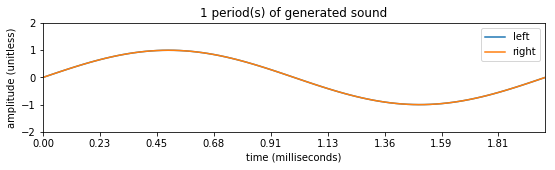

In [3]:
#Generate the tone
tone = ToneMaker(samplerate=44100, duration=6)
tone.addfreq(frequency=500, amplitude=1)

#plot the tone
tone.plot_stereo(periods=1)

#play the tone
tone.play_stereo()

## Exploring localization cues

Now we can see what happens to the graph *and* to our perception when we start playing with simple localization cues.

First, we'll build a simple sine wave of 750Hz.




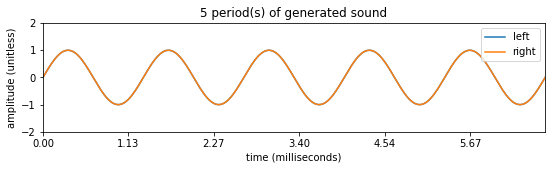

In [4]:
#Generate the tone
tone = ToneMaker(samplerate=44100, duration=5)
tone.build_harmonic(f0=750, nsteps=1)

#plot the tone
tone.plot_stereo(periods=5)

#play the tone
tone.play_stereo()

### Interaural Time Differences


We can see that the period of this tone is about 1.3 milliseconds.

Now, let's introduce an interaural timing difference of 1/10 period, or 0.13 milliseconds, and see what that does to our impression of where the sound is coming from.

We can do this to both the left and the right ears, and compare.



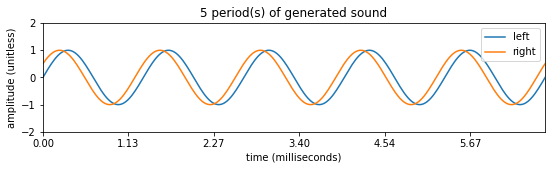

In [5]:
#Generate a tone, and send sound to the RIGHT ear 0.13 milliseconds early.
tone = ToneMaker(samplerate=44100, duration=2)
tone.build_harmonic(f0=750, nsteps=1)

#Adding the ITD:
tone.add_itd(milliseconds_early=0.13, side="right")

tone.plot_stereo(periods=5)

tone.play_stereo()

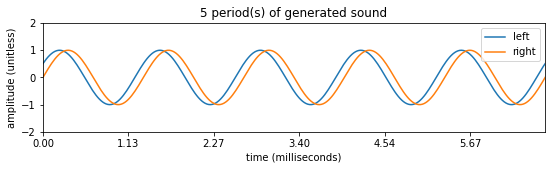

In [6]:
#Generate a tone, and send sound to the LEFT ear 0.13 milliseconds early.
tone = ToneMaker(samplerate=44100, duration=2)
tone.build_harmonic(f0=750, nsteps=1)

#Adding the ITD:
tone.add_itd(milliseconds_early=.13, side="left")

tone.plot_stereo(periods=5)

tone.play_stereo()

Most humans have our best sensitivity to ITDs at frequencies of about 750 to 1000 Hz. In lab conditions, thresholds can be as low as *10 microseconds* (Brughera et al., 2013). Try entering different values of `f0` and `delay` to see where your thresholds are in this setup.

Notice that with 750Hz and a .13 ms offset, it's easy to look at this picture and see which sound "comes first". As you increase the tone's frequency, however, it becomes harder and harder to say whether one sound is coming before or after the other.

Note: Sound travels through air at 343 meters per second. If your ears are about 15-20 centimeters apart from each other, real-life sounds will never hit one ear much later than 0.5 milliseconds after the other.

### Interaural Intensity Differences

Now let's try with changes in sound intensity. We'll use the same 750Hz sine wave, but this time instead of changing the timing of the ears, we'll change their volume.

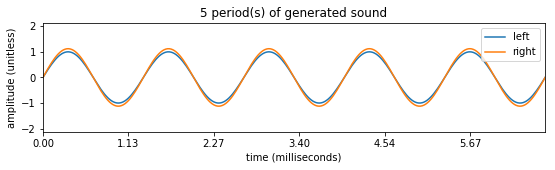

In [7]:
#Generate a tone, and make the RIGHT ear 0.5dB louder.
tone = ToneMaker(samplerate=44100, duration=2)
tone.build_harmonic(f0=750, nsteps=1)

#Adding the ILD:
tone.add_ild(decibels=0.5, side="right")

tone.plot_stereo(periods=5)

tone.play_stereo()

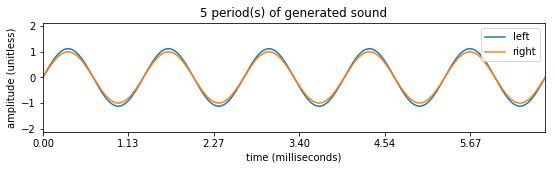

In [8]:
#Generate a tone, and make the LEFT ear 0.5 dB louder.
tone = ToneMaker(samplerate=44100, duration=2)
tone.build_harmonic(f0=750, nsteps=1)
tone.add_ild(decibels=0.5, side="left")
tone.plot_stereo(periods=5)

tone.play_stereo()

Most humans have our *worst* sensitivity to ILDs at frequencies of about 800 to 1200 Hz. Outside this range, we can notice an interaural difference of about 0.5 decibels, or 12% (Yost & Dye, 1988). Try entering different values of `decibels` and `f0` to see where your thresholds are in this setup. Remember, decibels are a logarithmic scale. An increase of 3 decibels will double amplitude, and 7 decibels will make it 5 times higher.

Note: Our head does a better job of blocking high frequency sound than low frequency sounds (just think of how car windows block high-pitch instruments, but not the bass). While a 100Hz sound will be almost the same in both ears, at 5kHz, the close ear will be about 20 decibels louder (Dorman et al., 2014).

### Putting them together

In real life, we use both ITDs and ILDs in combination.

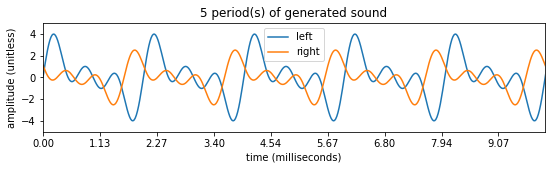

In [9]:
#Complex tones with multiple location cues.
tone = ToneMaker(samplerate=44100, duration=2)
tone.build_harmonic(f0=500, nsteps=3)

#Adding the cues:
tone.add_ild(decibels=2, side="left")
tone.add_itd(milliseconds_early=0.4, side="right")

tone.plot_stereo(periods=5)

tone.play_stereo()

Now, we can compare how the cues impact our impression of where the sound is coming from at different signal frequencies.

Try setting the `side` parameter in `add_ild` and `add_itd` to opposite ears from one another. Note how the illusion of sound coming from one side or the other becomes a little bit muddled.

We know that timing differences aren't very useful at high frequencies (because we can't tell which side came 'first'). You can see that in action by changing `f0` to a very high frequency, and seeing that the sound's direction becomes less ambiguous, even though the cues still disagree.

#### References

Brughera, A., Dunai, L., & Hartmann, W. M. (2013). Human interaural time difference thresholds for sine tones: The high-frequency limit. The Journal of the Acoustical Society of America, 133(5), 2839-2855. [doi](https://dx.doi.org/10.1121%2F1.4795778)

Dorman, M. F., Loiselle, L., Stohl, J., Yost, W. A., Spahr, A., Brown, C., & Cook, S. (2014). Interaural level differences and sound source localization for bilateral cochlear implant patients. Ear and hearing, 35(6), 633. [pubmed](https://www.ncbi.nlm.nih.gov/pubmed/25127322)

Macpherson, E. A., & Middlebrooks, J. C. (2002). Listener weighting of cues for lateral angle: the duplex theory of sound localization revisited. The Journal of the Acoustical Society of America, 111(5), 2219-2236. [doi](https://doi.org/10.1121/1.1471898)

Wang, D., & Brown, G. J. (2006). Computational auditory scene analysis: Principles, algorithms, and applications. Wiley-IEEE press. [pdf](https://www.cs.cmu.edu/~robust/Papers/SternWangBrownChapter.pdf)

Yost, W. A., & Dye Jr, R. H. (1988). Discrimination of interaural differences of level as a function of frequency. The Journal of the Acoustical Society of America, 83(5), 1846-1851. [doi](https://doi.org/10.1121/1.396520)

